In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import json
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [57]:

PATH = "/Users/sdutta7/Documents/mlfinalproject/training_data"
EXT = "*.csv"
all_csv_files = []
for path, subdir, files in os.walk(PATH):
    for file in glob(os.path.join(path, EXT)):
        all_csv_files.append(file)
print(len(all_csv_files))

107


In [ ]:

headers = []
with open('config.json') as f:
    headers = json.load(f)

i=0
df = pd.DataFrame(columns = headers)
for path in all_csv_files:    
    i+=1
    print("i - ",i)
    df_new = pd.read_csv(path,names=headers)
    df = df.append(df_new, ignore_index = True)
    if i==1:
        break
    
arr1_120 = [ 'Laser'+str(i+1) for i in range(0,120)]
df['laser_1_120'] = df[arr1_120].mean(axis=1)   

arr121_240 = [ 'Laser'+str(i+1) for i in range(120,240)]
df['laser_121_240'] = df[arr121_240].mean(axis=1)   

arr241_360 = [ 'Laser'+str(i+1) for i in range(240,360)]
df['laser_241_360'] = df[arr241_360].mean(axis=1) 

arr361_480 = [ 'Laser'+str(i+1) for i in range(360,480)]
df['laser_361_480'] = df[arr361_480].mean(axis=1)     

arr481_600 = [ 'Laser'+str(i+1) for i in range(480,600)]
df['laser_481_600'] = df[arr481_600].mean(axis=1)    

arr601_720 = [ 'Laser'+str(i+1) for i in range(600,720)]
df['laser_601_720'] = df[arr601_720].mean(axis=1)  
arr721_840 = [ 'Laser'+str(i+1) for i in range(720,840)]
df['laser_721_840'] = df[arr721_840].mean(axis=1)  

arr841_960 = [ 'Laser'+str(i+1) for i in range(840,960)]
df['laser_841_960'] = df[arr841_960].mean(axis=1)  

arr961_1080 = [ 'Laser'+str(i+1) for i in range(960,1080)]
df['laser_961_1080'] = df[arr961_1080].mean(axis=1)  

df = df.iloc[: , 1080:]
X = df[["Final_goal_x","Final_goal_y","Final_goal_qk","Final_goal_qr","Local_goal_x","Local_goal_y","Local_goal_qk","Local_goal_qr","Robot_pos_x","Robot_pos_y","Robot_pos_qr","Robot_pos_qk","laser_1_120","laser_121_240","laser_241_360","laser_361_480","laser_481_600","laser_601_720","laser_721_840","laser_841_960","laser_961_1080"]]
y = df[["Cmd_vel_v","Cmd_vel_w"]]
print(X.shape,y.shape)
X = np.array(X)
y = np.array(y)




In [10]:
from sklearn.model_selection import train_test_split
X, XValidation, y, yValidation = train_test_split(X,y,test_size=0.2,random_state=42) # before model building
print(X.shape,y.shape,XValidation.shape,yValidation.shape)

(114801, 21) (114801, 2) (28701, 21) (28701, 2)


In [18]:
# define the keras model
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(2, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Neural Networks for Robot')


# model_neural = Sequential()
# model_neural.add(Dense(12, input_dim=21, activation='relu'))
# model_neural.add(Dense(8, activation='relu'))
# model_neural.add(Dense(2, activation='sigmoid'))
# model_neural.compile(optimizer='adam',
#               loss='mse',
#               metrics=['accuracy','mse',])

In [19]:
print(X.shape,y.shape)
# history = model_neural.fit(X, y, batch_size=100,validation_data=(XValidation,yValidation),epochs=10)
# pickle.dump(model_neural, open('finalized_robot_nural.sav', 'wb')) 
tuner.search(X, y,
             epochs=10,
             validation_data=(XValidation,yValidation))

Trial 5 Complete [00h 05m 39s]
val_mean_absolute_error: 0.2344270497560501

Best val_mean_absolute_error So Far: 0.08370533585548401
Total elapsed time: 00h 18m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
model_all = tuner.hypermodel.build(best_hps)
model_all_copy = model_all
history_all = model_v1.fit(X, y, epochs=10)
history_all_validate = model_all_copy.fit(XValidation,yValidation,epochs=10)
pickle.dump(model_all, open('finalized_robot_neural_all.sav', 'wb'))


In [45]:
best_hps = tuner.get_best_hyperparameters()[0]
model_v1 = tuner.hypermodel.build(best_hps)
history_v1 = model_v1.fit(X, y, epochs=10)
model_v1 = tuner.hypermodel.build(best_hps)
history_validate_v1 = model_v1.fit(XValidation,yValidation, epochs=5)
# validation_data=(XValidation,yValidation)

Epoch 1/5
3588/3588 [==============================] - 14s 4ms/step - loss: 0.1135 - mean_absolute_error: 0.1135
Epoch 2/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0978 - mean_absolute_error: 0.0978
Epoch 3/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0932 - mean_absolute_error: 0.0932
Epoch 4/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0884 - mean_absolute_error: 0.0884
Epoch 5/5
3588/3588 [==============================] - 13s 4ms/step - loss: 0.0852 - mean_absolute_error: 0.0852
Epoch 1/5
897/897 [==============================] - 4s 4ms/step - loss: 0.1360 - mean_absolute_error: 0.1360
Epoch 2/5
897/897 [==============================] - 3s 4ms/step - loss: 0.1112 - mean_absolute_error: 0.1112
Epoch 3/5
897/897 [==============================] - 3s 4ms/step - loss: 0.1056 - mean_absolute_error: 0.1056
Epoch 4/5
897/897 [==============================] - 3s 4ms/step - loss: 0.1030 - mean_absolute_error: 0.

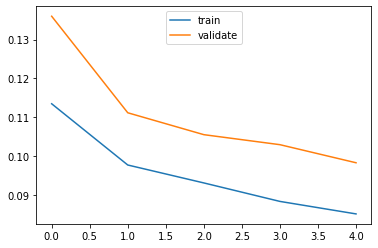

In [55]:
# plot metrics

from matplotlib import pyplot
pyplot.plot(history_v1.history['mean_absolute_error'],label="train")
pyplot.plot(history_validate_v1.history['mean_absolute_error'],label="validate")
pyplot.legend(loc='upper center')
# pyplot.plot(history.history['accuracy'])
pyplot.show()

In [ ]:
#performance 
